# Data Analysis with MCMC

We will use MCMC to sample the posterior probability distribution for a simple model, fitting y=f(x;theta)

Relevant Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Define model function and generate fake data
Here func() is our model function: the height of a falling object as a function time (x).  It has model parameters h0, v0, and g, the initial height, velocity, and gravitational acceleration.

genData() generates N datapoints evenly sampled in time with independent Gaussian errors (amplitude sig).

<ErrorbarContainer object of 3 artists>

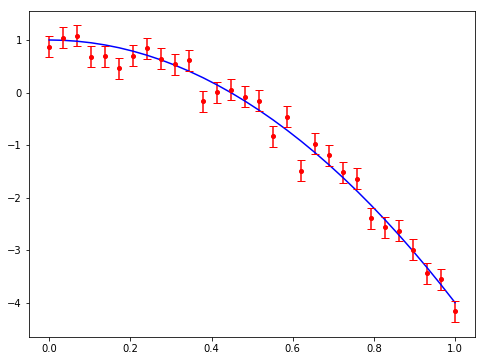

In [23]:
def func(x, h0, v0, g):
    return h0 + v0*x + 0.5*g*x*x

def genData(N, h0, v0, g, sig):
    x = np.linspace(0,1,N)
    y = func(x, h0, v0, g)
    yerr = np.ones(N)*sig
    r = np.random.randn(N)
    y += yerr*r
    
    return x, y, yerr

N = 30
h0 = 1.0
v0 = 0.0
g = -10
sig = 0.2
x, y, yerr = genData(N, h0, v0, g, sig)

#Plot data we made
fig, ax = plt.subplots(1,1, figsize=(8,6) )
ax.plot( x, func(x,h0,v0,g), color='b')
ax.errorbar( x, y, yerr, ls='', capsize=4, color='r', marker='o', ms=4)

### Sampling the Posterior

Let us forget that we know the 'true' values of h0, v0, g, and let us determine them based on the noisy data we created.  In our model errors are independent and gaussian, so the Likelihood is Chi2.  We also assume flat priors.

We create a Sampler object, an array of initial positions in parameter space, and run the MCMC

In [24]:
import emcee

def logpost( theta, x, y, yerr ):
    ymodel = func(x, *theta)
    chi2 = ( ((y-ymodel)/yerr)**2).sum()
    logprior = 0.0
    loglike = -0.5*chi2
    return logprior + loglike

nwalkers = 100
ndim = 3
niterations = 2000
sample = emcee.EnsembleSampler( nwalkers, ndim, logpost, args=[x,y,yerr])

p0 = [np.random.rand(ndim) for i in range(nwalkers)]
sampler_out = sample.run_mcmc(p0, niterations)

#### Sampling is done!

EnsembleSampler object has two important ways of viewing the samples: (1) chain has size (nwalkers, niterations, ndim) and (2) flatchain with size (nwalkers* niterations, ndim ).

In [25]:
chain = sample.chain
samples = sample.flatchain
print( chain.shape )
print( samples.shape )

(100, 2000, 3)
(200000, 3)


### View Model Realizations

We can plot the path of each walker for each parameter just to see what the walkers did.

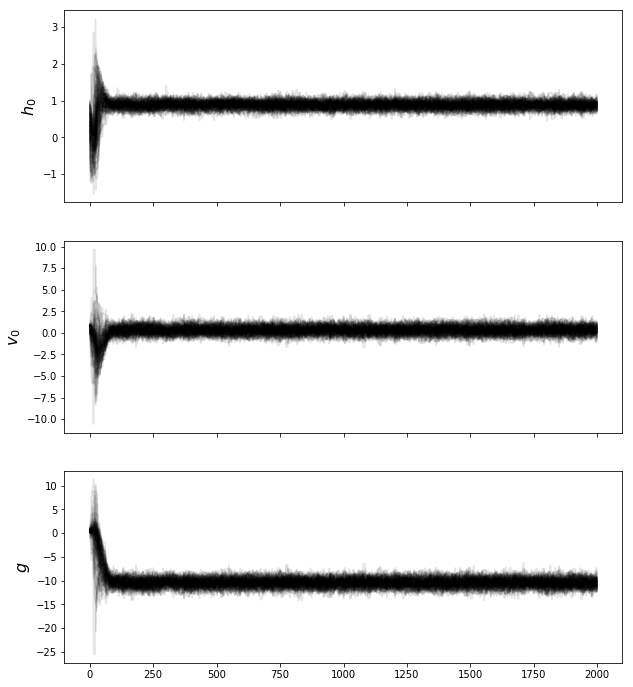

In [26]:
fig, ax = plt.subplots(ndim,1, sharex=True, figsize=(10,12) )

ts = np.arange( niterations )
labels = [r"$h_0$", r"$v_0$", r"$g$"]
for i in range(nwalkers):
    for dim in range(ndim):
        ax[dim].plot( ts, chain[i,:,dim], alpha=0.1, color='k')
        ax[dim].set_ylabel( labels[dim], fontsize=16 )

We can also plot realizations of each walker in its last iteration to give an idea of the distribution of possible curves

<ErrorbarContainer object of 3 artists>

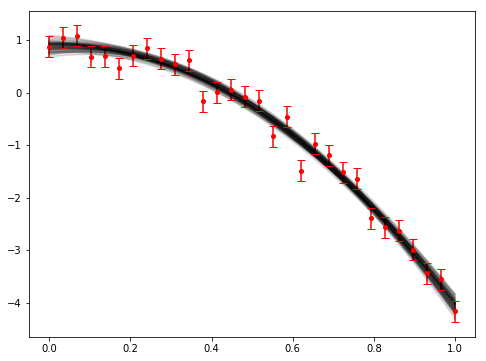

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for theta in chain[:,-1]:
    ax.plot( x, func(x, *theta), alpha=0.1, color='k')
ax.errorbar( x, y, yerr, ls='', capsize=4, color='r', marker='o', ms=4)

### Viewing the Posterior

We can use the corner package to view the distributions of each parameter and all the pairwise correlations in a convenient way. Corner takes flatchain data to plot.

However, we'll notice that if we use all of the samples, the distributions looks strange.  This is because the initial guess was far from the 'true' values of our parameters; and it took several steps for the walkers to reach the correct region of parameter space.

To work around this, we can 'trim' the data by just throwing the first half (this is called the 'burn-in' phase).

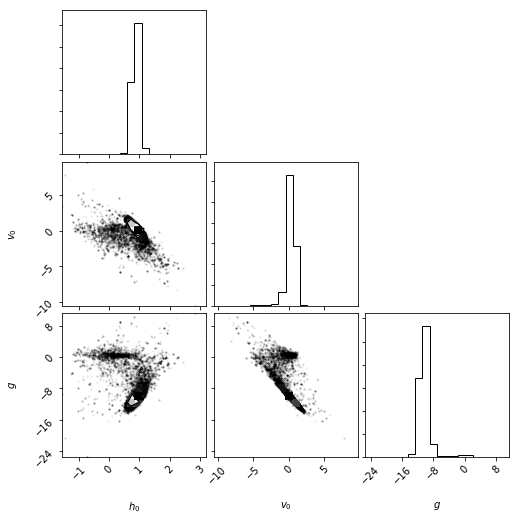

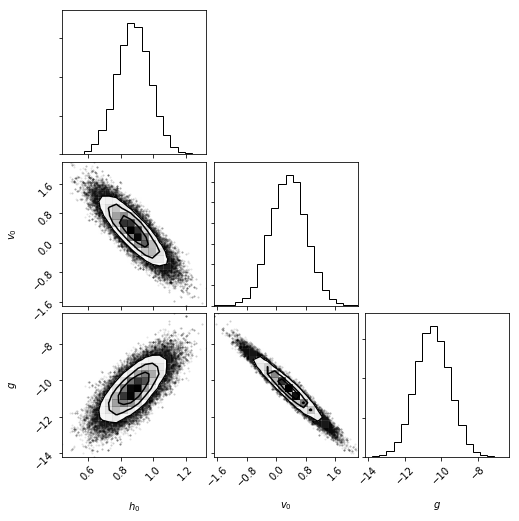

In [28]:
import corner
fig1 = corner.corner( samples, labels=[r"$h_0$", r"$v_0$", r"$g$"] )

samples_trim = np.resize( chain[:,int(niterations/2):,:], (-1,3))
fig2 = corner.corner( samples_trim, labels=[r"$h_0$", r"$v_0$", r"$g$"] )

#### Now we can make parameter estimates

We can report the expected values for each parameters

h0: 0.88 +/- 0.10
v0: 0.32 +/- 0.48
g : -10.47 +/- 0.93


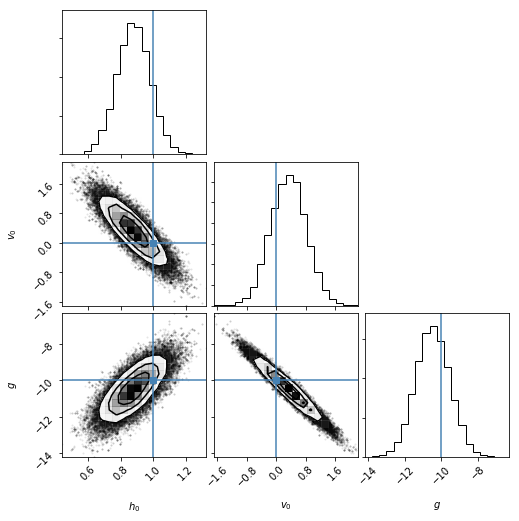

In [29]:
h_avg = samples_trim[:,0].mean()
v_avg = samples_trim[:,1].mean()
g_avg = samples_trim[:,2].mean()

h_sig = samples_trim[:,0].std()
v_sig = samples_trim[:,1].std()
g_sig = samples_trim[:,2].std()

print( "h0: {0:.2f} +/- {1:.2f}".format( h_avg, h_sig) )
print( "v0: {0:.2f} +/- {1:.2f}".format( v_avg, v_sig) )
print( "g : {0:.2f} +/- {1:.2f}".format( g_avg, g_sig) )

htrue = 1.0
vtrue = 0.0
gtrue = -10.0
fig3 = corner.corner( samples_trim, labels=[r"$h_0$", r"$v_0$", r"$g$"] , truths=[htrue, vtrue, gtrue] )


### Not great, but not horrible!